Работа на уроке с преподавателем по теме "Преобразование Хафа для решения прикладных задач"

In [87]:
# Подключение внешних модулей
import cv2
import numpy as np
from pyar import Camera, Point3D, Point2D, ForwardRectify, Size
import matplotlib.pyplot as plt
import matplotlib.patches as patches

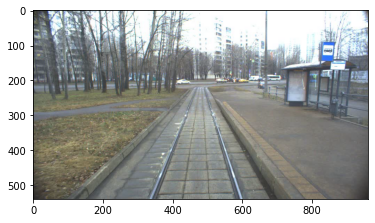

In [88]:
# чтение одной картинки
path_to_avi = '../data/city/trm.169.007.avi'
cap = cv2.VideoCapture(path_to_avi)
_, frame = cap.read()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()
cap.release()

In [89]:
frame.shape

(540, 960, 3)

In [90]:
# использование преобразования Хафа
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# Выделение границ детектором Канни
edges = cv2.Canny(gray, 0, 500)
# Поиск линий с помощью Хаффа
lines = cv2.HoughLinesP(
    edges,
    1,
    np.pi / 180,
    100,
    minLineLength=200,
    maxLineGap=10
)

In [91]:
# поэксперементировать с длинной 
count = 0
for line in lines:
    x1,y1,x2,y2 = line[0]
    if x1 != x2:
        cv2.line(frame,(x1,y1),(x2,y2),(255, 0, 0), 2)
    else:
        count = count + 1

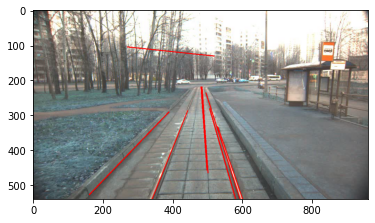

In [92]:
plt.imshow(frame)
plt.show()

In [93]:
# пост процессинг
# чтение калибов
file_name = '../data/city/leftImage.yml'
cam = Camera.from_yaml(file_name)
p = cam.project_point(Point3D(0, 20, 0))
P2 = cam.reproject_point_with_height(p, 0)


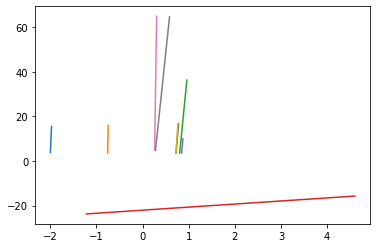

In [94]:
XY = np.zeros([len(lines), 4])
for count, line in enumerate(lines):
    x1,y1,x2,y2 = line[0]
    P1 = cam.reproject_point_with_height(Point2D(x1, y1), 0)
    P2 = cam.reproject_point_with_height(Point2D(x2, y2), 0)
    XY[count, :2] = [P1.x, P1.y]
    XY[count, 2:] = [P2.x, P2.y]
    plt.plot((P1.x, P2.x), (P1.y, P2.y))
plt.show()

In [95]:
# зададим зону
X = [-5, 5]
Y = [5, 15]

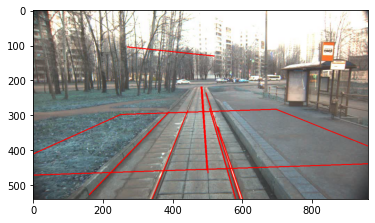

In [96]:
# визуализация зону на изображении
p1 = cam.project_point(Point3D(X[0], Y[0], 0))
p2 = cam.project_point(Point3D(X[0], Y[1], 0))
p3 = cam.project_point(Point3D(X[1], Y[1], 0))
p4 = cam.project_point(Point3D(X[1], Y[0], 0))
# 
roi_corners = np.array([(p1.x, p1.y), (p2.x, p2.y), (p3.x, p3.y), (p4.x, p4.y)], dtype=np.int32)
cv2.line(frame, roi_corners[0,:],roi_corners[1,:],(255, 0, 0), 2)
cv2.line(frame, roi_corners[1,:],roi_corners[2,:],(255, 0, 0), 2)
cv2.line(frame, roi_corners[2,:],roi_corners[3,:],(255, 0, 0), 2)
cv2.line(frame, roi_corners[3,:],roi_corners[0,:],(255, 0, 0), 2)
plt.imshow(frame)
plt.show()  

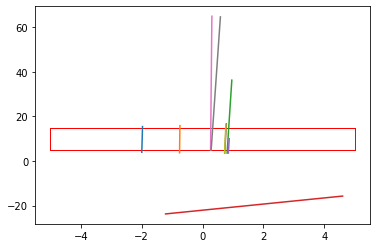

In [97]:
# визуализируем зону на плоскости
for count, line in enumerate(lines):
    plt.plot((XY[count, 0], XY[count, 2]), (XY[count, 1], XY[count, 3]))
    rect = patches.Rectangle((X[0], Y[0]), X[1] - X[0], Y[1] - Y[0], linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
plt.show()

In [98]:
# создадим маску
mask = np.zeros(frame.shape, dtype=np.uint8)
cv2.fillPoly(mask, [roi_corners], (255, 255, 255))
masked_image = cv2.bitwise_and(frame, mask)

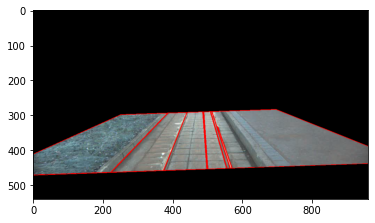

In [99]:
plt.imshow(masked_image)
plt.show()

In [100]:
x0, y0 = 0, 0 
# найдем параметры
# P = (Px, Py) thetta
param = np.zeros([len(XY), 2])
for index, xy in enumerate(XY):
    thetta = np.arctan2(xy[3] - xy[1], xy[2] - xy[0])
    r = abs(np.cos(thetta) * (xy[1] - y0)  - np.sin(thetta) * (xy[0] - x0))
    r = r * np.sign(xy[0] - x0)
    param[index, :] = [r, thetta]


In [101]:
def norm(x):
    return np.exp(-0.5 * x**2)/np.sqrt(2 * np.pi)

In [102]:
# ограничения
w = 0.5
flag = np.zeros([len(XY), len(XY)])
for i in np.arange(0, len(XY)):
    for j in np.arange(i + 1, len(XY)):
        r1 = param[i, 0]
        r2 = param[j, 0]
        thetta1 = param[j, 1]
        thetta2 = param[j, 1]
        probability = w * norm(abs(r1 - r2) - 1.54) + (1 - w) * norm(thetta1 - thetta2)
        flag[i, j] = probability

In [103]:
# две пары рельс
indexs = np.where(flag == flag.max())
track1 = lines[indexs[0][0]]
track2 = lines[indexs[1][0]]

track1

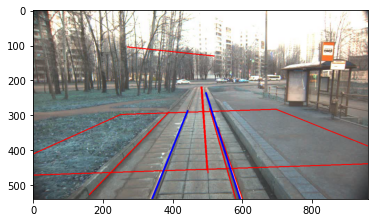

In [104]:
# отрисовка результата
cv2.line(frame, track1[0][:2], track1[0][2:],(0, 0, 255), 3)
cv2.line(frame, track2[0][:2], track2[0][2:],(0, 0, 255), 3)
plt.imshow(frame)
plt.show() 

Визуализация результата в динамике, алгоритм

In [106]:
cap = cv2.VideoCapture(path_to_avi)
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
    # Алгоритм:
    # наложите на изображение маску
    # найдите с использованием преобразования Хафа линии
    # проведите селекцию линий и выберите "наилучшие"
    # отобразите на изображении результат
    cv2.imshow('Video',frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
  else: 
    break
cap.release()
cv2.destroyAllWindows()